In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES
from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True

yearRange = [1981, 2019]

In [4]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [10]:
minCropYears = 10
minCropYearsDeepak = 10

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)):
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [11]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [12]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [13]:
usCounties = usCounties.drop(index=inds)

In [22]:
curCountyList = usCounties.copy()

In [14]:
countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYieldDetrend = np.array(list(usCounties['maizeYieldDetrendPlusMean']))
countyMaizeYield = np.array(list(usCounties['maizeYield']))
countyMaizeYieldDetrendAnom = np.array(list(usCounties['maizeYieldDetrend']))

countySoybeanYieldDetrend = np.array(list(usCounties['soybeanYieldDetrendPlusMean']))
countySoybeanYield = np.array(list(usCounties['soybeanYield']))
countySoybeanYieldDetrendAnom = np.array(list(usCounties['soybeanYieldDetrend']))

countyTotalProd = np.array([y*a for y,a in zip(countyMaizeYield, countyMaizeHaAc)] + [y*a for y,a in zip(countySoybeanYield, countySoybeanHaAc)])

In [47]:
useDeepak = False

with gzip.open('cc-feedback-analysis.dat', 'rb') as f:
    ccFeedbackAnalysis = pickle.load(f)

In [78]:
fipsSel = ccFeedbackAnalysis['fipsSel']
irSel = ccFeedbackAnalysis['irSel']

mdl_LH_Y_Coefs = ccFeedbackAnalysis['mdl_LH_Y_Coefs']
mdl_LH_Y_PValues = ccFeedbackAnalysis['mdl_LH_Y_PValues']

lhTrendFrac = ccFeedbackAnalysis['lhTrendFrac']
lhFromFeedback = ccFeedbackAnalysis['lhFromFeedback']
lhChgFeedbackWithAgInt = ccFeedbackAnalysis['lhChgFeedbackWithAgInt']
lhChgFeedbackWithoutAgInt = ccFeedbackAnalysis['lhChgFeedbackWithoutAgInt']

shTrendFrac = ccFeedbackAnalysis['shTrendFrac']
shFromFeedback = ccFeedbackAnalysis['shFromFeedback']
shChgFeedbackWithAgInt = ccFeedbackAnalysis['shChgFeedbackWithAgInt']
shChgFeedbackWithoutAgInt = ccFeedbackAnalysis['shChgFeedbackWithoutAgInt']

gddTrendFrac = ccFeedbackAnalysis['gddTrendFrac']
gddFromFeedback = ccFeedbackAnalysis['gddFromFeedback']
gddChgFeedbackWithAgInt = ccFeedbackAnalysis['gddChgFeedbackWithAgInt']
gddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['gddChgFeedbackWithoutAgInt']

kddTrendFrac = ccFeedbackAnalysis['kddTrendFrac']
kddFromFeedback = ccFeedbackAnalysis['kddFromFeedback']
kddChgFeedbackWithAgInt = ccFeedbackAnalysis['kddChgFeedbackWithAgInt']
kddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['kddChgFeedbackWithoutAgInt']

maizeYieldTrendFrac = ccFeedbackAnalysis['maizeYieldTrendFrac']
maizeYieldFromFeedback = ccFeedbackAnalysis['maizeYieldFromFeedback']
maizeYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithAgInt']
maizeYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithoutAgInt']

soybeanYieldTrendFrac = ccFeedbackAnalysis['soybeanYieldTrendFrac']
soybeanYieldFromFeedback = ccFeedbackAnalysis['soybeanYieldFromFeedback']
soybeanYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithAgInt']
soybeanYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithoutAgInt']

tFromFeedback = ccFeedbackAnalysis['tFromFeedback']


# ccFeedbackAnalysis = {

#     'fipsSel':fipsSel,
#     'haExclude':haExclude,
#     'irSel':irSel,
#     'shortSeriesExclude':shortSeriesExclude,
#     'nonSigExclude':nonSigExclude,
    
#     'lhTrendFrac':lhTrendFrac,
#     'lhFromFeedback':lhFromFeedback,
#     'lhChgFeedbackWithAgInt':lhChgFeedbackWithAgInt,
#     'lhChgFeedbackWithoutAgInt':lhChgFeedbackWithoutAgInt,
    
#     'shTrendFrac':shTrendFrac,
#     'shFromFeedback':shFromFeedback,
#     'shChgFeedbackWithAgInt':shChgFeedbackWithAgInt,
#     'shChgFeedbackWithoutAgInt':shChgFeedbackWithoutAgInt,
    
#     'gddTrendFrac':gddTrendFrac,
#     'gddFromFeedback':gddFromFeedback,
#     'gddChgFeedbackWithAgInt':gddChgFeedbackWithAgInt,
#     'gddChgFeedbackWithoutAgInt':gddChgFeedbackWithoutAgInt,
    
#     'kddTrendFrac':kddTrendFrac,
#     'kddFromFeedback':kddFromFeedback,
#     'kddChgFeedbackWithAgInt':kddChgFeedbackWithAgInt,
#     'kddChgFeedbackWithoutAgInt':kddChgFeedbackWithoutAgInt,
    
#     'maizeYieldTrendFrac':maizeYieldTrendFrac,
#     'maizeYieldFromFeedback':maizeYieldFromFeedback,
#     'maizeYieldChgFeedbackWithAgInt':maizeYieldChgFeedbackWithAgInt,
#     'maizeYieldChgFeedbackWithoutAgInt':maizeYieldChgFeedbackWithoutAgInt,
    
#     'soybeanYieldTrendFrac':soybeanYieldTrendFrac,
#     'soybeanYieldFromFeedback':soybeanYieldFromFeedback,
#     'soybeanYieldChgFeedbackWithAgInt':soybeanYieldChgFeedbackWithAgInt,
#     'soybeanYieldChgFeedbackWithoutAgInt':soybeanYieldChgFeedbackWithoutAgInt,
    
#     'tFromFeedback':tFromFeedback,
    
#     'mdl_LH_Y_Coefs':mdl_LH_Y_Coefs,
#     'mdl_LH_Y_PValues':mdl_LH_Y_PValues,
    
#     'mdl_LH_SH_Coefs':mdl_LH_SH_Coefs,
#     'mdl_LH_SH_PValues':mdl_LH_SH_PValues,
    
#     'mdl_SH_KDD_Coefs':mdl_SH_KDD_Coefs,
#     'mdl_SH_KDD_PValues':mdl_SH_KDD_PValues,
    
#     'mdl_SH_GDD_Coefs':mdl_SH_GDD_Coefs,
#     'mdl_SH_GDD_PValues':mdl_SH_GDD_PValues,
    
#     'mdl_KDD_GDD_MaizeYield_Coefs':mdl_KDD_GDD_MaizeYield_Coefs,
#     'mdl_KDD_GDD_MaizeYield_PValues':mdl_KDD_GDD_MaizeYield_PValues,
    
#     'mdl_KDD_GDD_SoybeanYield_Coefs':mdl_KDD_GDD_SoybeanYield_Coefs,
#     'mdl_KDD_GDD_SoybeanYield_PValues':mdl_KDD_GDD_SoybeanYield_PValues,
    
# }


In [53]:
np.nanmean(np.nanmean(np.nanmean(maizeYieldTrendFrac, axis=2), axis=1), axis=0)

13.828657854097179

In [79]:
# calculate mean yield, kdd, gdd, and trends across all counties to use for percent corrections in maps below

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeAllAc + haSoybeanAllAc
haAllFrac = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedAreaFraction']])*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])*10
gddTrendAll = np.array([a for a in usCounties['gddTrend']])*10
prTrendAll = np.array([a for a in usCounties['seasonalPrecipTrend']])*10

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeMeanAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanMeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeMeanAllAc + haSoybeanMeanAllAc
haTotalFracAll = haTotalAllAc/countyAcAll

meanPrAll = np.array([np.nanmean(a) for a in usCounties['seasonalPrecip']])

meanNetRadAll = np.array([np.nanmean(a) for a in usCounties['seasonalNetRad']])
meanSlhfAll = -np.array([np.nanmean(a) for a in usCounties['seasonalSlhf']])

if wxData == 'era5':
    countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
    meanNetRadAll /= countySeasonLenSec
    meanSlhfAll /= countySeasonLenSec

meanKddAll = np.array([np.nanmean(a) for a in usCounties['kdd']])
meanGddAll = np.array([np.nanmean(a) for a in usCounties['gdd']])

# convert slhf trend to w/m2/decade
slhfTrendAll = -np.array([a for a in usCounties['seasonalSlhfTrend']])
sshfTrendAll = -np.array([a for a in usCounties['seasonalSshfTrend']])
netRadTrendAll = np.array([a for a in usCounties['seasonalNetRadTrend']])

if wxData == 'era5':
    slhfTrendAll = [a*10/t for a,t in zip(slhfTrendAll, countySeasonLenSec)]
    sshfTrendAll = [a*10/t for a,t in zip(sshfTrendAll, countySeasonLenSec)]
    netRadTrendAll = [a*10/t for a,t in zip(netRadTrendAll, countySeasonLenSec)]

if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
    meanProdAll = meanYieldAll * haAllAc
else:
    maizeYieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])*10
    maizeYieldAll = np.array([a for a in usCounties['maizeYield']])
    maizeYieldMeanAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
    
    soybeanYieldTrendAll = np.array([a for a in usCounties['soybeanYieldTrend']])*10
    soybeanYieldAll = np.array([a for a in usCounties['soybeanYield']])
    soybeanYieldStdAll = np.array([np.nanstd(a) for a in usCounties['soybeanYield']])
    soybeanYieldMeanAll = np.nanmean(np.array([a for a in usCounties['soybeanYield']]), axis=1)
    
    maizeYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    soybeanYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    for c in range(maizeYieldAll.shape[0]):
        nn = np.where(~np.isnan(maizeYieldAll[c,:]))[0]
        if np.nansum(maizeYieldAll[c,nn]) > 0:
            maizeYieldStdAll[c] = np.nanstd(scipy.signal.detrend(maizeYieldAll[c,nn]))
        
        nn = np.where(~np.isnan(soybeanYieldAll[c,:]))[0]
        if np.nansum(soybeanYieldAll[c,nn]) > 0:
            soybeanYieldStdAll[c] = np.nanstd(scipy.signal.detrend(soybeanYieldAll[c,nn]))
    
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    
    totalProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldMeanAll, countySoybeanHaAc)])
    maizeProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)])
    totalProdMeanLast5All = np.full(totalProdMeanAll.shape, np.nan)
    totalProdTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    totalProdOverTimeAll = np.full(maizeYieldAll.shape[1]-1, 0)
    totalHaTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    for c in range(totalProdMeanAll.size):
        p_maize = np.array([x[0]*x[1] for x in zip(maizeYieldAll[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(soybeanYieldAll[c,:], countySoybeanHaAc[c,:])])
        nn_maize = np.where(~np.isnan(p_maize))[0]
        nn_soybean = np.where(~np.isnan(p_soybean))[0]
        
        totalProdMeanLast5All[c] = np.nanmean(p_maize[nn_maize[-5:]]) + np.nanmean(p_soybean[nn_soybean[-5:]])
        
        for y in range(totalProdOverTimeAll.shape[0]):
            if ~np.isnan(p_maize[y]):
                totalProdOverTimeAll[y] += p_maize[y]
            if ~np.isnan(p_soybean[y]):
                totalProdOverTimeAll[y] += p_soybean[y]
        
        if len(nn_maize) >= 10:
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(p_maize[nn_maize],X).fit()
            totalProdTrendAll[c] = mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(countyMaizeHaAc[c,nn_maize],X).fit()
            totalHaTrendAll[c] = mdl.params[1]
        if len(nn_soybean) >= 10:
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(p_soybean[nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalProdTrendAll[c] = mdl.params[1]
            else:
                totalProdTrendAll[c] += mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(countySoybeanHaAc[c, nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalHaTrendAll[c] = mdl.params[1]
            else:
                totalHaTrendAll[c] += mdl.params[1]

nn = np.where((totalProdTrendAll > 0) & (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & (~np.isnan(haTotalFracAll)) & (mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05))[0]
nnIr = np.where((totalProdTrendAll > 0) & (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & (~np.isnan(haTotalFracAll)) & (~np.isnan(irSel)) & (mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05))[0]
nnNonIr = np.where((totalProdTrendAll > 0) & (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & (~np.isnan(haTotalFracAll)) & (np.isnan(irSel))& (mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05))[0]
# noOutlierInd = np.where((abs(scipy.stats.zscore(lhFromFeedback[nn]/haTotalFracAll[nn])) < 1))[0]
adjNn = nn#[noOutlierInd]
# adjNnIr = np.intersect1d(adjNn, irSel)

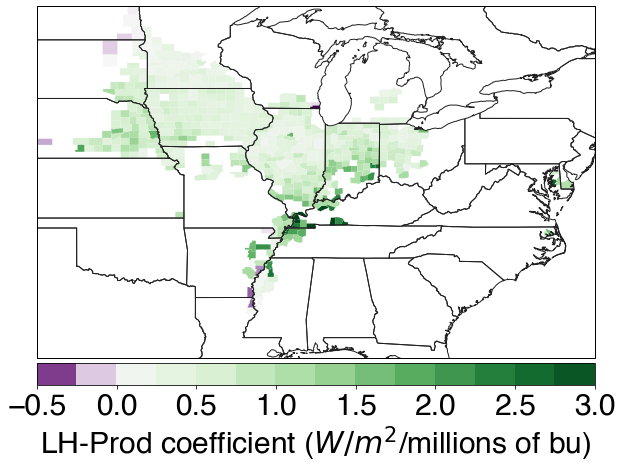

In [46]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -0.5
v2 = 3.1
vcenter = 0
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Prod coefficient ($W/m^2$/millions of bu)', fontsize=mapFontSize)
# plt.savefig('coef-lh-prod.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

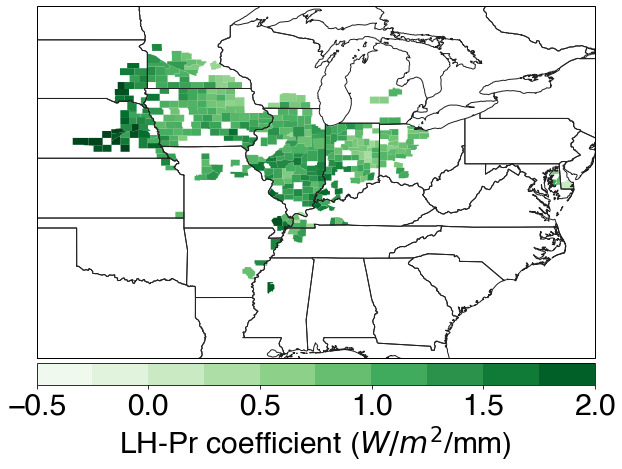

In [81]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = 2.1
vcenter = (v1+v2)/2
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['Pr_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Pr coefficient ($W/m^2$/mm)', fontsize=mapFontSize)
# plt.savefig('coef-lh-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

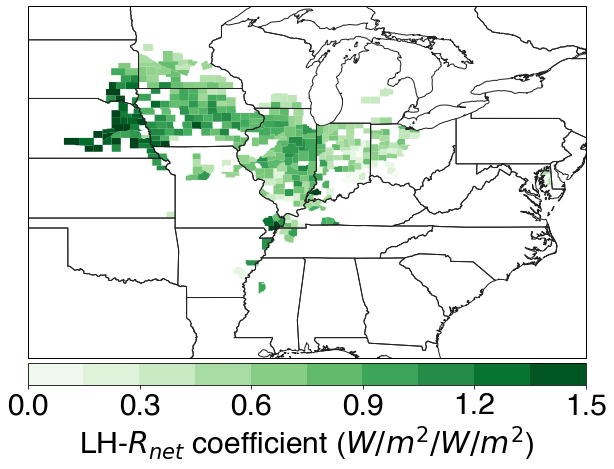

In [82]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 1.51
vcenter = (v1+v2)/2
vstep = .15
vlabelstep = .3

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['NetRad_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-$R_{net}$ coefficient ($W/m^2/W/m^2$)', fontsize=mapFontSize)
# plt.savefig('coef-lh-rnet.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 2.1
vcenter = 0
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['Wind_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Wind coefficient ($W/m^2$/m/s)', fontsize=mapFontSize)
plt.savefig('coef-lh-wind.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1.1
v2 = -.899
vcenter = (v1+v2)/2
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_SH_Coefs['SLHF_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('SH-LH coefficient ($W/m^2$/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-sh-lh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = .9
v2 = 1.051
vcenter = (v1+v2)/2
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds_r')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_SH_Coefs['NetRad_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('SH-$R_{net}$ coefficient ($W/m^2$/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-sh-netrad.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 3
v2 = 10.1
vcenter = (v1+v2)/2
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_SH_KDD_Coefs['SSHF_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD-SH coefficient (KDDs/year/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-kdd-sh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 2
v2 = 20.1
vcenter = (v1+v2)/2
vstep = 1.5
vlabelstep = 3

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_SH_GDD_Coefs['SSHF_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD-SH coefficient (GDDs/year/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-gdd-sh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

NameError: name 'mdl_KDD_GDD_MaizeYield_Coefs' is not defined

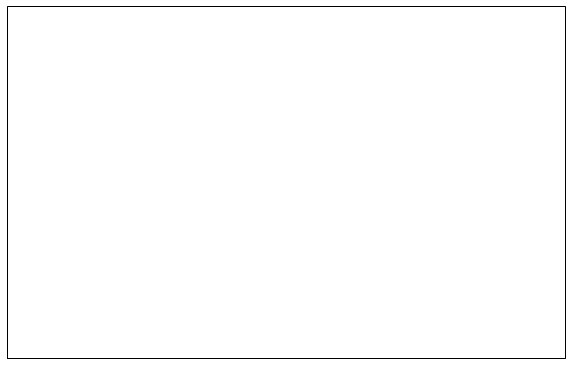

In [83]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = .6
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['KDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-KDD coefficient (bu/ac/KDD)', fontsize=mapFontSize)
# plt.savefig('coef-maize-yield-kdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.2
v2 = .21
vstep = .025
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-KDD coefficient (bu/ac/KDD)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-kdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.1
v2 = .16
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['GDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-GDD coefficient (bu/ac/GDD)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-gdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['GDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-GDD coefficient (bu/ac/GDD)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-gdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -4
v2 = 2.1
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['Pr_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-Pr coefficient (bu/ac/mm)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['Pr_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-Pr coefficient (bu/ac/mm)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

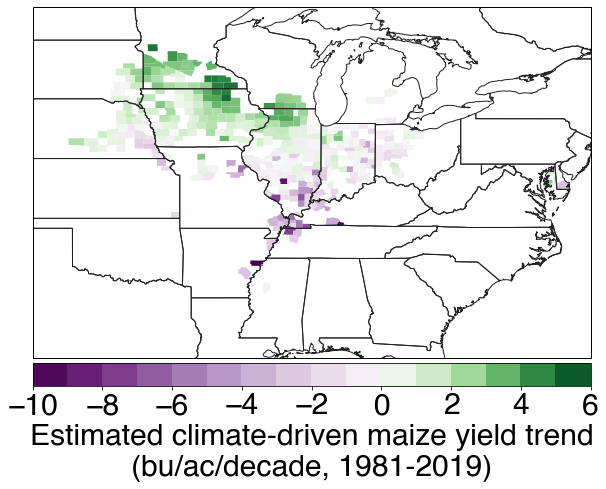

In [113]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -10
    v2 = 6.1
    vstep = 1
    vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

data = np.nanmean(np.nanmean(maizeYieldChgFeedbackWithAgInt, axis=2), axis=1)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = maizeYieldChgFeedbackWithAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = data[ind[0]]
#             curVal = maizeYieldChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven maize yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-maize-yield-change-ag-int-95th-p.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

-3.0796919163807233


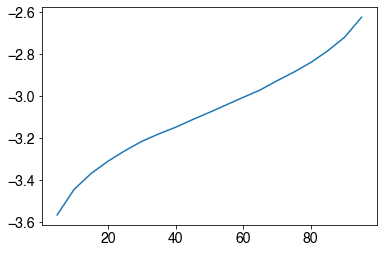

In [109]:
# median yield change without ag int
# np.nanmedian(np.nanmean(np.nanmean(maizeYieldChgFeedbackWithoutAgInt[adjNn], axis=2), axis=1))

maizeYieldChgFeedbackWithoutAgInt_uncert_1d = np.reshape(maizeYieldChgFeedbackWithoutAgInt[adjNn,:,:], [len(adjNn), maizeYieldChgFeedbackWithoutAgInt.shape[1]*maizeYieldChgFeedbackWithoutAgInt.shape[2]])
p = np.nanpercentile(np.nanmean(maizeYieldChgFeedbackWithoutAgInt_uncert_1d, axis=0), np.arange(5,96,5))
print(np.nanmean(maizeYieldChgFeedbackWithoutAgInt_uncert_1d))
plt.plot(np.arange(5,96,5),p)

0.12019491435122268


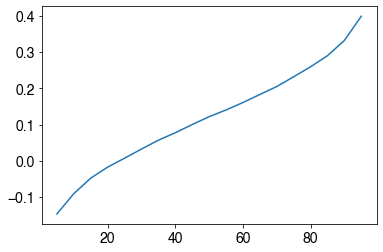

In [106]:
maizeYieldChgFeedbackWithAgInt_uncert_1d = np.reshape(maizeYieldChgFeedbackWithAgInt[adjNn,:,:], [len(adjNn), maizeYieldChgFeedbackWithAgInt.shape[1]*maizeYieldChgFeedbackWithAgInt.shape[2]])
p = np.nanpercentile(np.nanmean(maizeYieldChgFeedbackWithAgInt_uncert_1d, axis=0), np.arange(5,96,5))
print(np.nanmean(maizeYieldChgFeedbackWithAgInt_uncert_1d))
plt.plot(np.arange(5,96,5),p)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -10
    v2 = 6.1
    vstep = 1
    vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = maizeYieldChgFeedbackWithoutAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = maizeYieldChgFeedbackWithoutAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('No agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# plt.xlabel('Climate-driven yield change with warming and no ag-int (% 1981-2019)', fontsize=mapFontSize)

#     cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
         boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
         pad=0.01, aspect=25, shrink=1)

cb.ax.tick_params(labelsize=mapFontSize)

if showPct:
#     cb.set_label('Climate-driven yield change with warming and no ag-int (% 1981-2019)', fontsize=mapFontSize)
    cb.set_label('Climate-driven maize yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('climate-driven-maize-yield-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

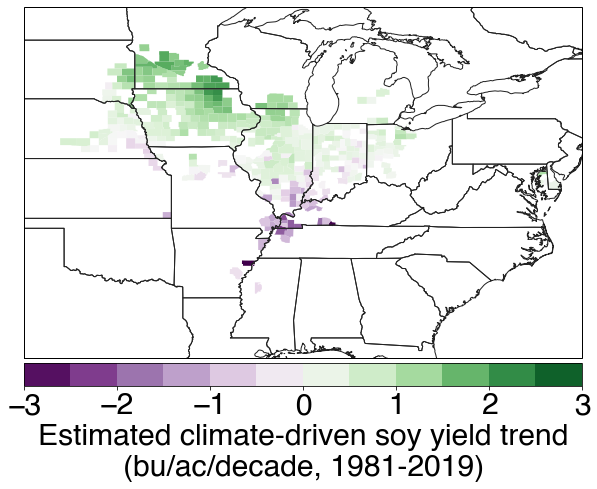

In [114]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -3
    v2 = 3.1
    vstep = .5
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

data = np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithAgInt, axis=2), axis=1)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = soybeanYieldChgFeedbackWithAgInt[ind[0]]/soybeanMeanYieldAll[ind[0]]*100
        else:
            curVal = data[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven soybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven soy yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-soybean-yield-change-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

-0.19600455300570713


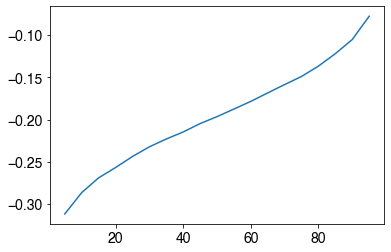

In [115]:
# np.nanmedian(soybeanYieldChgFeedbackWithAgInt[adjNn])

# median yield change without ag int
# np.nanmedian(np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt[adjNn], axis=2), axis=1))

soybeanYieldChgFeedbackWithoutAgInt_uncert_1d = np.reshape(soybeanYieldChgFeedbackWithoutAgInt[adjNn,:,:], [len(adjNn), soybeanYieldChgFeedbackWithoutAgInt.shape[1]*soybeanYieldChgFeedbackWithoutAgInt.shape[2]])
p = np.nanpercentile(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt_uncert_1d, axis=0), np.arange(5,96,5))
print(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt_uncert_1d))
plt.plot(np.arange(5,96,5),p)

0.34811485691397026


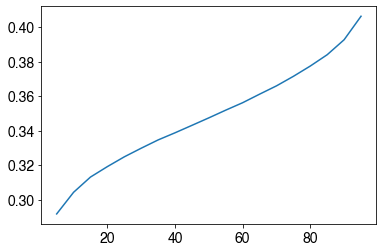

In [117]:
# np.nanmedian(soybeanYieldChgFeedbackWithoutAgInt[adjNn])

soybeanYieldChgFeedbackWithAgInt_uncert_1d = np.reshape(soybeanYieldChgFeedbackWithAgInt[adjNn,:,:], [len(adjNn), soybeanYieldChgFeedbackWithAgInt.shape[1]*soybeanYieldChgFeedbackWithAgInt.shape[2]])
p = np.nanpercentile(np.nanmean(soybeanYieldChgFeedbackWithAgInt_uncert_1d, axis=0), np.arange(5,96,5))
print(np.nanmean(soybeanYieldChgFeedbackWithAgInt_uncert_1d))
plt.plot(np.arange(5,96,5),p)

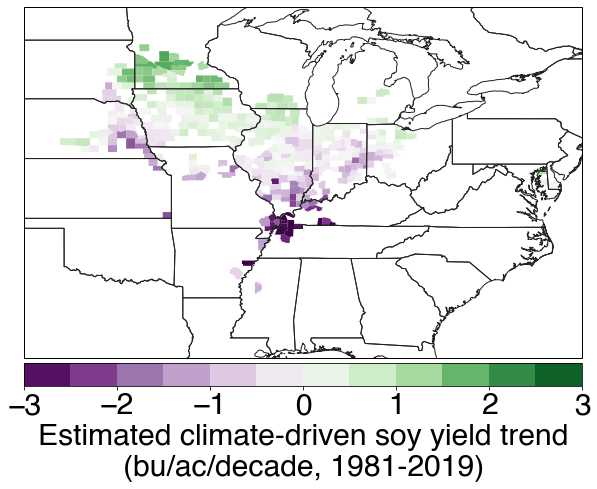

In [118]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -3
    v2 = 3.1
    vstep = .5
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

data = np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt, axis=2), axis=1)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = soybeanYieldChgFeedbackWithoutAgInt[ind[0]]/soybeanMeanYieldAll[ind[0]]*100
        else:
            curVal = data[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven soybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven soy yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-soybean-yield-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 71
vstep = 2
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = kddChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Observed, with ag-int', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('kdd-change-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -20
v2 = 61
vstep = 5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = kddChgFeedbackWithoutAgInt[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Estimated, without ag-int', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated KDD trend\n(KDDs/season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-change-no-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -50
    v2 = 11
    vcenter = 0
    vstep = 2
    vlabelstep = 10
else:
    v1 = -60
    v2 = 10.1
    vcenter = 0
    vstep = 5
    vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = kddFromFeedback[ind[0]]/meanKddAll[ind[0]]*100
        else:
            curVal = kddFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('KDD trend from production\n(%/decade, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated KDD trend from production\n(KDDs/season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 50
v2 = 171
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = maizeYieldMeanAll[ind[0]]

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))

            if len(ind) > 0 and ind[0] in adjNn:
                ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean yield (bu/ac, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('us-mean-yield-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 30.1
vcenter = (v1+v2)/2
vstep = 1
vlabelstep = 5
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        
        # convert bu/ac to kg/ac
        curVal = maizeYieldTrendAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-maize-yield-trend-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
np.nanmedian(maizeYieldTrendAll[adjNn])

In [ ]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -5
v2 = 15.1
vcenter = 0
vstep = 1
vlabelstep = 5
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

# build merged polygon for included region
includedPolys = []
irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
#         if curFips in irExclude:
#             try:
#                 irExcludedPolys.append(Polygon(county.geometry))
#             except:
#                 irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
# polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)



for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalProdTrendAll[ind[0]]*10/1e6

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))

#             if len(ind) > 0:
#                 if curFips in irExclude:
#                     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize+soybean production trend\n(millions of bu/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-prod-trend-maize-soy-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 50.1
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

# build merged polygon for included region
includedPolys = []
# irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
#         if curFips in irExclude:
#             try:
#                 irExcludedPolys.append(Polygon(county.geometry))
#             except:
#                 irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
# polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)


for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalProdMeanAll[ind[0]]/1e6

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor=None, lw=0, facecolor=cmap(midnorm(curVal))))

#             if curFips in irExclude:
#                 ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))
# ax.add_feature(ShapelyFeature(polyUnionIrExcludedRegion, ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean maize+soybean production\n(millions of bu, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-prod-maize-soy-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 20.1
vcenter = 0
vstep = 2.5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('RdYlGn')

# build merged polygon for included region
includedPolys = []
# irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
#         if curFips in irExclude:
#             try:
#                 irExcludedPolys.append(Polygon(county.geometry))
#             except:
#                 irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
# polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)


for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalHaTrendAll[ind[0]]/countyAcAll[ind[0]]*100*10

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor=None, lw=0, facecolor=cmap(midnorm(curVal))))

#             if curFips in irExclude:
#                 ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))
# ax.add_feature(ShapelyFeature(polyUnionIrExcludedRegion, ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Harvested fraction trend\n(%/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-ha-frac-trend-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 80.1
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

# build merged polygon for included region
includedPolys = []
# irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
#         if curFips in irExclude:
#             try:
#                 irExcludedPolys.append(Polygon(county.geometry))
#             except:
#                 irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
# polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)


for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = haTotalAllAc[ind[0]]/countyAcAll[ind[0]]*100

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor=None, lw=0, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))
# ax.add_feature(ShapelyFeature(polyUnionIrExcludedRegion, ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean maize+soy harvested fraction\n(%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-ha-frac-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
hfrac = haTotalAllAc[adjNn]/countyAcAll[adjNn]*100
ind=np.where(hfrac>75)[0]
len(ind)/len(adjNn)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 10
v2 = 56
vcenter = (v1+v2)/2
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        
        # convert bu/ac to kg/ac
        curVal = soybeanYieldMeanAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield (bu/ac, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('us-mean-yield-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 8.1
vcenter = (v1+v2)/2
vstep = .25
vlabelstep = 1
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        
        curVal = soybeanYieldTrendAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-soybean-yield-trend-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
np.nanmedian(soybeanYieldTrendAll[adjNn])

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 301
vcenter = (v1+v2)/2
vstep = 25
vlabelstep = 50

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = meanKddAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean KDDs\n(KDDs/season, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-kdd-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])

v1 = -10
v2 = 35.1
vcenter = 0
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = kddTrendAll[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='gray', facecolor='white'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    # ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend\n(KDDs/season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-trend-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 1200
v2 = 2801
vcenter = (v1+v2)/2
vstep = 100
vlabelstep = 400

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = meanGddAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean GDDs\n(GDDs/season, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-gdd-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 30
v2 = 77
vcenter = (v1+v2)/2
vstep = 2
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = gddTrendAll[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='gray', facecolor='white'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend\n(GDDs/season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-trend-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -10
    v2 = 11
    vstep = 2
else:
    v1 = -10
    v2 = 83
    vstep = 3
    vlabelstep = 10

vcenter = 0

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = gddChgFeedbackWithAgInt[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddChgFeedbackWithAgInt[ind[0]]
#         curVal = gddFromFeedback[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-change-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -10
    v2 = 11
    vstep = 2
else:
    v1 = -20
    v2 = 101
    vstep = 10
    vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = gddChgFeedbackWithoutAgInt[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddChgFeedbackWithoutAgInt[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('No agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated GDD trend\n(GDDs/season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -4
    v2 = 1.1
    vcenter = 0
    vstep = .25
    vlabelstep=1
else:
    v1 = -60
    v2 = 10.1
    vcenter = 0
    vstep = 5
    vlabelstep=10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = gddFromFeedback[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('GDD trend from production\n(%/decade, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated GDD trend from production\n(GDDs/season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

v1 = -.4
v2 = .11
vcenter = 0
vstep = .05
vlabelstep=.1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = tFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated temperature trend from production\n($\degree$C/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('t-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 51
vcenter = 0
vstep = 2.5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curYieldTrendFrac = maizeYieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac) and abs(curYieldTrendFrac) <= 100:
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Feedback contribution to total\nmaize yield trend (%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-maize-yield-trend-frac-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
np.nanmedian(maizeYieldTrendFrac[adjNn])

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 51
vcenter = 0
vstep = 2.5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curYieldTrendFrac = soybeanYieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac) and abs(curYieldTrendFrac) <= 100:
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Feedback contribution to total\nsoybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-soybean-yield-trend-frac-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
np.nanmedian(soybeanYieldTrendFrac[adjNn])

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -2
v2 = 5.1
vcenter = 0
vstep = .25
vlabelstep = 1


midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PiYG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = lhFromFeedback[ind[0]]#*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated LH trend from production\n($W/m^2/$decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('lh-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
X = sm.add_constant(haTotalFracAll[adjNn])
mdl = sm.OLS(lhFromFeedback[adjNn], X).fit()

x1 = .1
x2 = .9

plt.figure(figsize=(6,6))
plt.xlim([0, 1])
plt.ylim([-2.5, 6.5])
plt.scatter(haTotalFracAll[adjNn], lhFromFeedback[adjNn])
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='p < 0.01')
plt.xlabel('Harvested fraction', fontsize=24)
plt.ylabel('LH from production\n($W/m^2$/decade)', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('lh-chg-from-prod-vs-ha-no-outliers.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -5
v2 = 2.1
vcenter = 0
vstep = .25
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PiYG_r')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        # convert from /ac to /m2
        curVal = shFromFeedback[ind[0]]#*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated SH trend from production\n($W/m^2/$decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('sh-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 8.1
vcenter = 0
vstep = .5
vlabelstep=1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = maizeYieldFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated maize yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('maize-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
np.nanmedian(maizeYieldFromFeedback[adjNn])

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = 2.01
vcenter = 0
vstep = .125
vlabelstep=.5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = soybeanYieldFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated soy yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('soybean-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
np.nanmedian(soybeanYieldFromFeedback[adjNn])

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])


v1 = -4
v2 = 1.1
vcenter = 0
vstep = .5
vlabelstep=1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = maizeYieldFromProdTrend_HistGrowth[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated maize yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('maize-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)